In [1]:
%ls

BenJackCode/                               matrix_expansion.py
change_notes.txt                           munkres.py
experiments.ipynb                          pybasicbayes/
fdr.cpython-310-x86_64-linux-gnu.so*       README.md
hmmbase.py                                 test_hmmbatchcd.py
hmmbatchcd.py                              test_hmmbatchsgd.py
hmmbatchsgd.py                             util.py
hmm_fast.cpython-310-x86_64-linux-gnu.so*


In [6]:
from test_hmmbatchcd import *
# from test_hmmbatchsgd import *

We do 3 approximation tests using "test_hmmbatchsgd.py" and "test_hmmbatchscd.py".

## SGD

Hamming Distance =  0.0


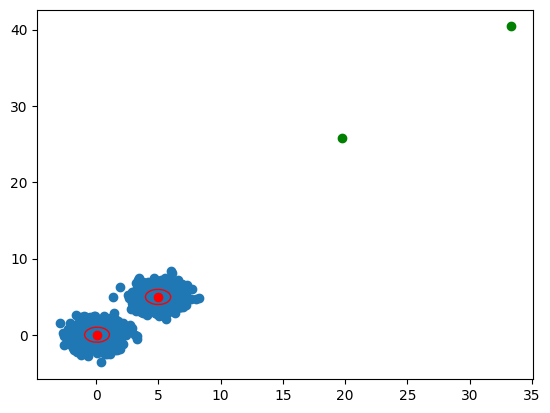

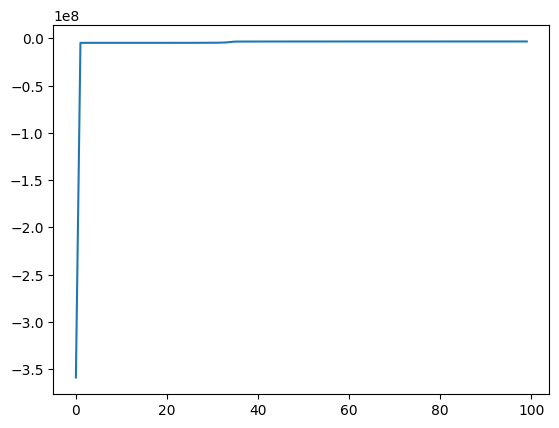

Hamming Distance =  0.0


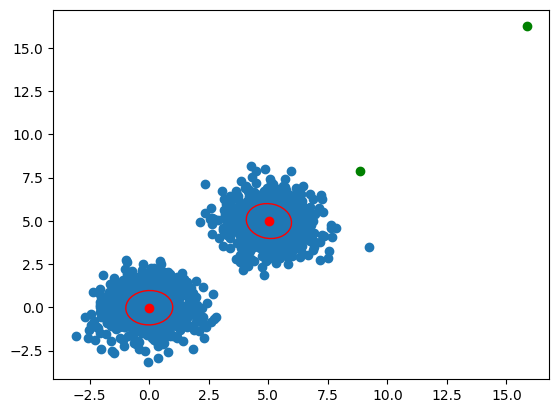

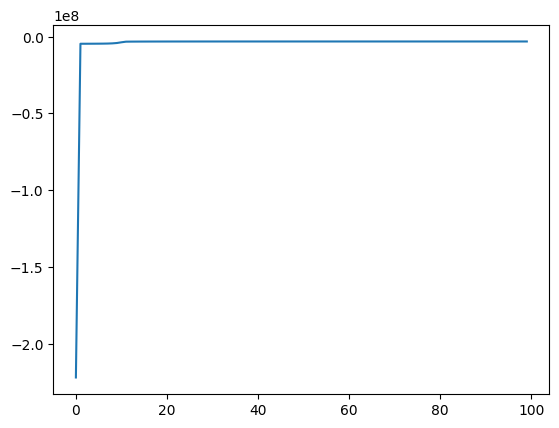

Hamming Distance =  0.0


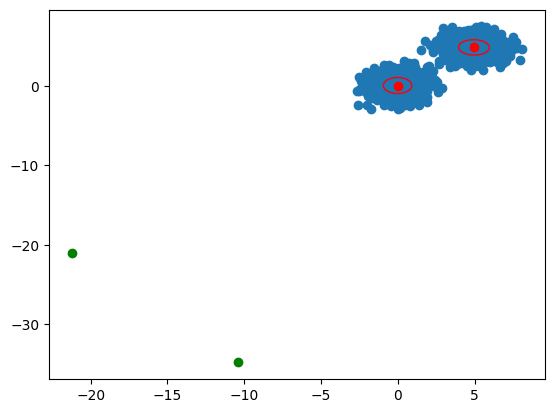

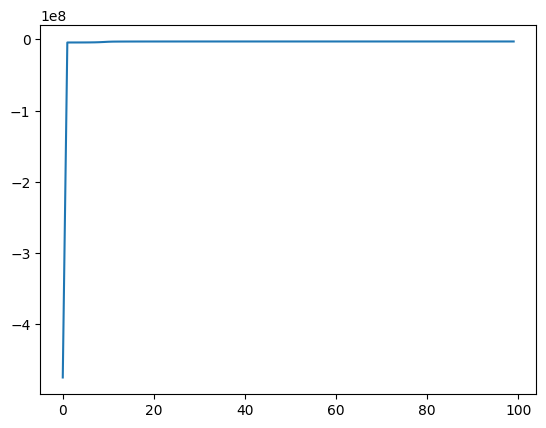

In [8]:
# for i in range(3):
    # test_hmmbatchsgd()

## CD

terminated early - convergence
Hamming Distance =  0.0


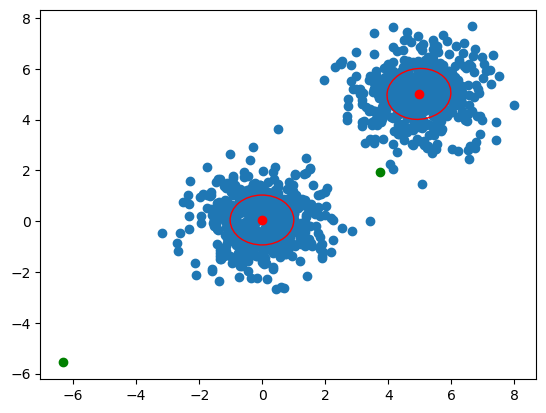

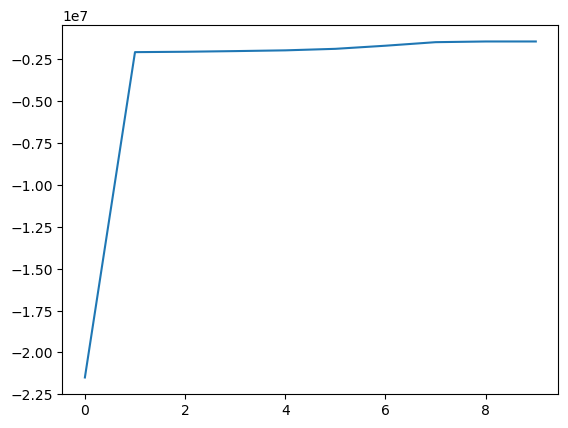

terminated early - convergence
Hamming Distance =  0.0


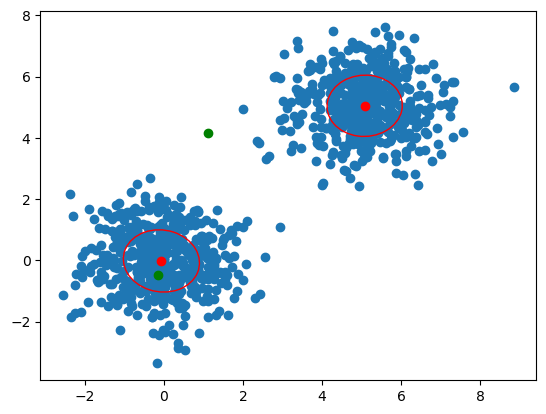

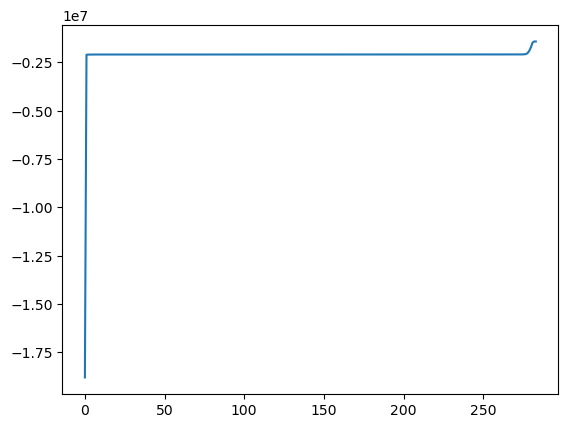

terminated early - convergence
Hamming Distance =  0.0


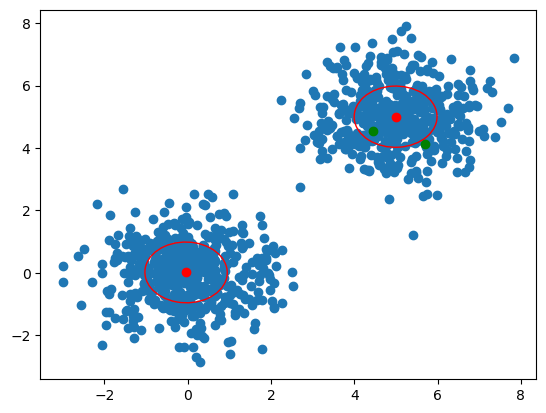

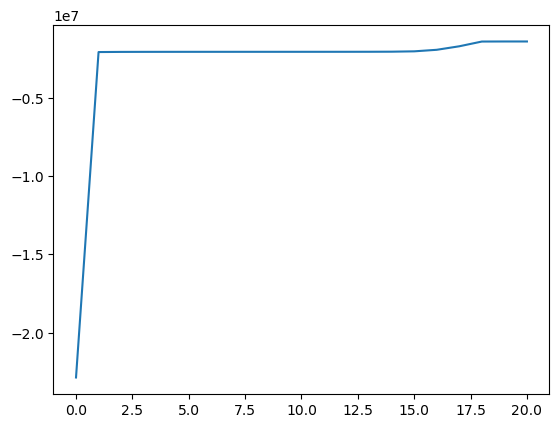

In [4]:
for i in range(3):
    test_hmmbatchcd()

### Interactive testing with comparision

ToDO  - finish this section

In [5]:
def generate_states(T: np.array, n_obs: int):

    states = [i for i in range(1,T.shape[0]+1)]
    state_seq = [np.random.randint(1,states[-1]+1)]
    for i in range(n_obs-1):
        state_seq.append(np.random.choice(states,p=T[state_seq[-1]-1]))
    
    ind_for_state_j = [np.where(np.asarray(state_seq)==j) for j in states]

    return np.asarray(state_seq,dtype=int), ind_for_state_j

def generate_data(emit : np.array, ind_for_state_j: np.array):
    obs = np.zeros((sum([len(j[0]) for j in ind_for_state_j]),2))
    for states in range(len(ind_for_state_j)):
        obs[ind_for_state_j[states]] = emit[states].rvs(size = len(ind_for_state_j[states][0]))
    return obs



terminated early - convergence
Hamming Distance =  0.484


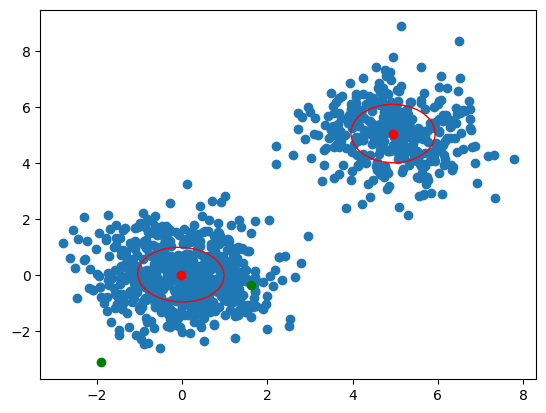

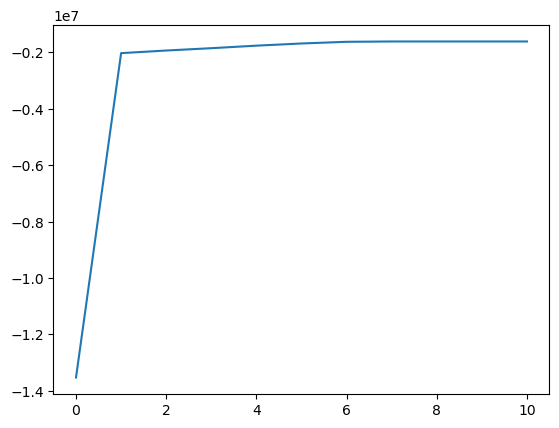

In [105]:
# code from test_hmmbatchcd
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmbatchcd as HMM

from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *


# generating toy data using emissions (in 2 dimensions)

K = 2           # number of states  
D = K           #have to be equal (symmetry)
kappa_0 = 1     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

# define priors on emission to be multivariate gaussian with 0 mean and unit var (no covariance)

jump = 5
emit1 = Gaussian(mu=np.array([0,0]),
                    sigma=np.eye(2),
                    mu_0=np.zeros(2),
                    sigma_0=np.eye(2),
                    kappa_0=kappa_0,
                    nu_0=nu_0)
emit2 = Gaussian(mu=np.array([0,0])+jump,    # distance of blobs
                    sigma=np.eye(2),    # variance of blobs
                    mu_0=np.zeros(2),   # prior
                    sigma_0=np.eye(2),  # prior
                    kappa_0=kappa_0,    # prior
                    nu_0=nu_0)          # prior
emit = np.array([emit1, emit2])

# generate state sequence with n_obs time steps based on transition matrix T

T = np.array([[0.9,0.1],[0.2,0.8]])
N = 1000


seq, ind = generate_states(T,N)

obs = generate_data(emit,ind)
# generate observations


# obs = np.array([emit[int(np.round(i/N))].rvs()[0]
#                 for i in range(N)])

# set priors on emissions to be 0 mean  
# 0.75 frac of empirical covariance matrix

mu_0 = np.zeros(D)
sigma_0 = 0.75*np.cov(obs.T)
kappa_0 = 0.5
nu_0 = 4

# define emisssion RV for each state (2)
prior_emit = [Gaussian(mu_0=mu_0, sigma_0=sigma_0, kappa_0=kappa_0, 
                        nu_0=nu_0) for _ in range(K)]
prior_emit = np.array(prior_emit)           # prior on emissions retype
prior_tran = np.ones(K*K).reshape((K,K))    # prior on transition matrix all 1
prior_init = np.ones(K)                     # ?

# define object for inferrence from hmmbatchcd.py
# pass priors on init transitions and emissions for each state
hmm = HMM.VBHMM(obs, prior_init, prior_tran, prior_emit,maxit=10000, epsilon=10**(-10))  
hmm.infer() # do inference 

sts_true = np.array([int(np.round(i/N)) for i in range(N)]) # true states 
# hamming distance
print('Hamming Distance = ', hmm.hamming_dist(hmm.var_x, sts_true)[0]) 

# plot learned emissions over observations

# plots mean_field values (prior in green, posterior approximations in red)
# prior values are green
# var_emit are red 
util.plot_emissions(obs, prior_emit, hmm.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hmm.elbo_vec)
plt.show()

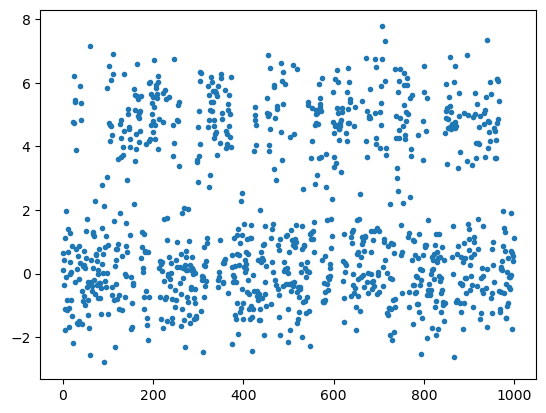

In [106]:
plt.plot(obs[:,0],'.')

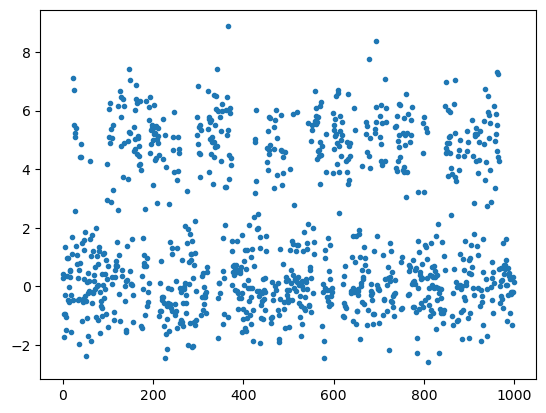

In [107]:
plt.plot(obs[:,1],'.')

In [7]:
hmm.var_emit[0].sigma_0*hmm.var_emit[0].kappa_0

array([[2.00504517, 1.64031709],
       [1.64031709, 2.01341442]])

In [8]:
phi_1 = hmm.var_emit[0].sigma
mu_11 , mu_12 = hmm.var_emit[0].mu_mf
mu_21 , mu_22 = hmm.var_emit[1].mu_mf
phi_2 = hmm.var_emit[1].sigma

## Jack's and Ben's code from stan analysis

In [9]:
import stan
import numpy as np
import nest_asyncio
nest_asyncio.apply()

dat = [tuple(i) for  i in obs]
data = {'y':dat , "N": N, "D":2, "K":2, 'mu_0':mu_0 , 'kappa_0':kappa_0, 'nu_0':nu_0,'Psi_0':sigma_0,'alpha_0':np.ones((K,D))} #specify dirichlet prior [1,1,1,...] on transitions

# read code from .stan file 
with open('BenJackCode/MvNormEmis_HMM.stan') as f:
    stan_code = f.read()

# build stan model 
jack_model = stan.build(stan_code,data)

N_MCMC = 1000 

# start sampling
fit = jack_model.sample(num_chains = 1, num_samples = 1000+N_MCMC, num_warmup = 1000 )

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_56a2ctxi/model_bggfrf6v.stan', line 10, column 50: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_56a2ctxi/model_bggfrf6v.stan', line 10, column 62: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_56a2ctxi/model_bggfrf6v.stan', line 11, column 26: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Ins

In [66]:
fit

<stan.Fit>
Parameters:
    mu: (2, 2)
    Sigma: (2, 2, 2)
    gamma: (2, 2)
Draws: 2000

In [70]:
import pandas as pd
import seaborn as sns
fr = pd.DataFrame(fit['mu'][0].T, columns = ['state 1 x1','state 1 x2'])
fr['state 2 x1'],fr['state 2 x2'] = fit['mu'][1]
sig = pd.DataFrame(np.asarray([fit['Sigma'][0][0][0],fit['Sigma'][0][1][1]]).T, columns = ['state 1 x1','state 1 x2'])
sig['state 2 x1'],sig['state 2 x2'] = np.asarray([fit['Sigma'][1][0][0],fit['Sigma'][1][1][1]])

gamm = pd.DataFrame(fit['gamma'][0].T, columns = ['state 1 x1','state 1 x2'])
gamm['state 2 x1'],gamm['state 2 x2'] = fit['gamma'][1]

In [115]:
# Estimated parameters
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import beta


# Estimated parameters
mu_mf1 = hmm.var_emit[1].mu_mf
sigma_mf1 = hmm.var_emit[1].sigma_mf
kappa_mf1 = hmm.var_emit[1].kappa_mf
nu_mf1 = hmm.var_emit[1].nu_mf

mu_mf0 = hmm.var_emit[0].mu_mf
sigma_mf0 = hmm.var_emit[0].sigma_mf
kappa_mf0 = hmm.var_emit[0].kappa_mf
nu_mf0 = hmm.var_emit[0].nu_mf
# Set up x-axis values for each dimension

# Set up x-axis values for each dimension

x01 = np.linspace(4.8, 5.2, 5000)
x11 = np.linspace(4.8, 5.2, 5000)


# Calculate scale matrix and degrees of freedom parameter
A1 = np.linalg.inv(sigma_mf1)

scale10 = A1[0,0] / kappa_mf1*(nu_mf1+2-1)
scale11 = A1[1,1] / kappa_mf1*(nu_mf1+2-1)

A0 = np.linalg.inv(sigma_mf0)

scale01 = A0[0,0] / kappa_mf0*(nu_mf0+2-1)
scale00 = A0[1,1] / kappa_mf0*(nu_mf0+2-1)

scales = [scale10,scale11,scale00,scale01]
dfs  = [nu_mf1]*2+[nu_mf0]*2
sigmas = [sigma_mf1,sigma_mf0]
kappas = [kappa_mf1,kappa_mf0]
# df1 = nu_mf1

# pdf10 = t.pdf(x01, df = nu_mf1, loc=mu_mf1[0], scale=scale10)
# pdf11 = t.pdf(x11, df = nu_mf1, loc=mu_mf1[1], scale=scale11)

# pdf00 = t.pdf(x01, df = nu_mf0, loc=mu_mf0[0], scale=scale00)
# pdf01 = t.pdf(x01, df = nu_mf0, loc=mu_mf0[1], scale=scale01)

# # Plot t-distribution pdfs for each dimension
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# ax1.plot(x11, pdf10)
# ax1.set_title('Student\'s t-distribution of μ0[0]')
# ax1.set_xlabel('μ[0]')
# ax1.set_ylabel('pdf')
# ax2.plot(x11, pdf11)
# ax2.set_title('Student\'s t-distribution of μ0[1]')
# ax2.set_xlabel('μ[1]')
# ax2.set_ylabel('pdf')
# plt.show()










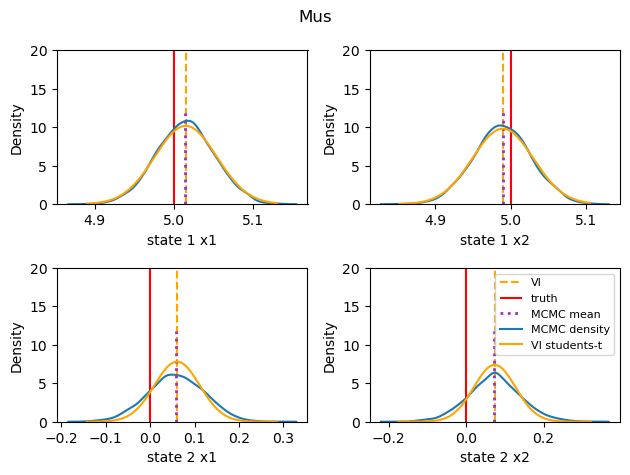

In [116]:
mus = [mu_21,mu_22,mu_11,mu_12]
phis = list(np.diag(phi_1))+list(np.diag(phi_2))
true_mus = [jump,jump,0,0]


# variance was set to 1 (identity)
for i, column in enumerate(fr.columns, 1):
    plt.subplot(2,2,i)
    plt.vlines(mus[i-1],0,20,color = 'orange',label='VI',linestyles='dashed')
    plt.vlines(true_mus[i-1],0,20,color = 'red',label='truth')
    plt.vlines(np.mean(fr[column]),0,12,color = 'darkorchid',linestyles='dotted',linewidth = 2, label='MCMC mean')
    sns.kdeplot(fr[column],label='MCMC density')
    x = np.linspace(min(fr[column]),max(fr[column]),500)
    plt.plot(x, t.pdf(x, df = dfs[i-1], loc=mus[i-1], scale=np.sqrt(scales[i-1])),label = 'VI students-t',color = 'orange')
    plt.ylim((0,20))
plt.suptitle('Mus')
plt.legend(fontsize = 8)
plt.tight_layout()
    

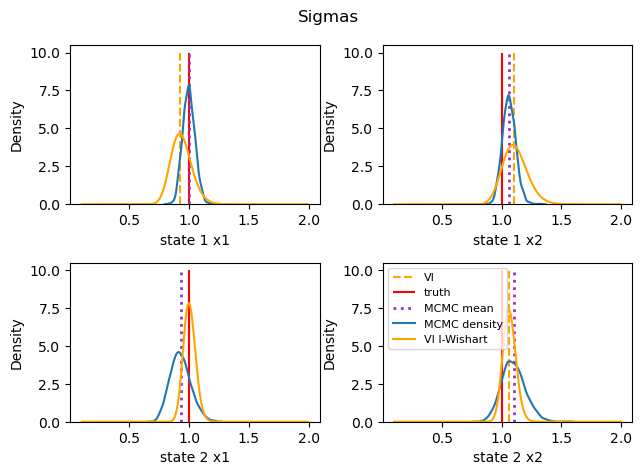

In [65]:
for i, column in enumerate(fr.columns, 1):
    plt.subplot(2,2,i)
    plt.vlines(phis[i-1],0,10,color = 'orange',label='VI',linestyles='dashed')
    plt.vlines(1,0,10,color = 'red',label='truth')
    plt.vlines(np.mean(sig[column]),0,10,color = 'darkorchid',linestyles='dotted',linewidth = 2, label='MCMC mean')
    sns.kdeplot(sig[column],common_norm=False,label='MCMC density')
    x = np.linspace(0.1,2,500)
    plt.plot(x, iw, label = 'VI I-Wishart',color = 'orange')
plt.suptitle('Sigmas')
plt.legend(fontsize = 8)
plt.tight_layout()

In [86]:
hmm.var_tran

array([[ 58.94498575, 175.00328499],
       [175.00328497, 594.04844429]])

In [90]:
T

array([[0.3, 0.7],
       [0.2, 0.8]])

In [117]:
alphas

[array([175.00328497, 594.04844429]), array([ 58.94498575, 175.00328499])]

In [95]:
alphas = [hmm.var_tran[1],hmm.var_tran[0]]

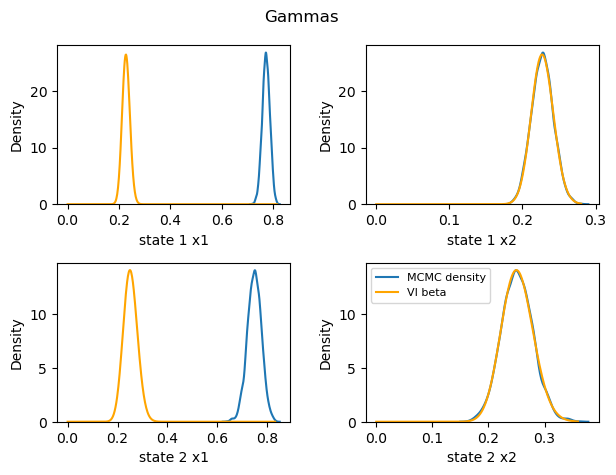

In [100]:
for i, column in enumerate(gamm.columns, 1):
    plt.subplot(2,2,i)
    # plt.vlines(mus[i-1],0,20,color = 'orange',label='VI',linestyles='dashed')
    # plt.vlines(true_mus[i-1],0,20,color = 'red',label='truth')
    # plt.vlines(np.mean(fr[column]),0,12,color = 'darkorchid',linestyles='dotted',linewidth = 2, label='MCMC mean')
    sns.kdeplot(gamm[column],label='MCMC density')
    x = np.linspace(0,max(gamm[column]),500)
    dist = beta.pdf(x,alphas[int(np.floor((i-1)/2))][0],alphas[int(np.floor((i-1)/2))][1])

    plt.plot(x, dist,label = 'VI beta',color = 'orange')
    # plt.ylim((0,20))
plt.suptitle('Gammas')
plt.legend(fontsize = 8)
plt.tight_layout()

## Matrix Expansion 

In [12]:
from matrix_expansion import *
test_matrix_expansion()

This is an example of how conversion HSMM to HMM transition matrix is done with expand_matrix()
The HSMM matrix is :
[[0.  0.8 0.2]
 [0.3 0.  0.7]
 [0.5 0.5 0. ]]
a_js are: [2 2 2]
lambda_js are: [1 2 3]
the 1- h vector is : [0.41802329 0.3038944 ]
the 1- h vector is : [0.68696471 0.54432116]
the 1- h vector is : [0.84281291 0.72024558]
sum of row entries :[1. 1. 1. 1. 1. 1.]
[[0.         0.41802329 0.46558137 0.         0.11639534 0.        ]
 [0.         0.3038944  0.55688448 0.         0.13922112 0.        ]
 [0.09391059 0.         0.         0.68696471 0.2191247  0.        ]
 [0.13670365 0.         0.         0.54432116 0.31897519 0.        ]
 [0.07859354 0.         0.07859354 0.         0.         0.84281291]
 [0.13987721 0.         0.13987721 0.         0.         0.72024558]]


In [31]:
from scipy.stats import poisson
import numpy as np 


''' function defined by jack with shifted poisson (gives 0  at state one i.e.)'''
# def h_j_pois(r : float, lambda_j: float):
#     h = poisson(mu = lambda_j)
#     if (1-h.cdf(x=r-2)) >= 1 : 
#         return 1
#     else:
#         return h.pmf(k=r-1)/(1-h.cdf(x=r-2))

# calculate hazard rates h_j(x)

def h_j_pois(r : float, lambda_j: float):
    h = poisson(mu = lambda_j)
    if (1-h.cdf(x=r-1)) >= 1 : 
        return 1
    else:
        return h.pmf(k=r)/(1-h.cdf(x=r-1))

    
def expand_matrix(T_hsmm, lambda_js_array , a_js_array):
    '''
    This function takes a valid transition 
    '''

    # check validity
    if not np.all(np.diagonal(T_hsmm) == 0):
        raise ValueError('This matrix is not valid. The diagonal entries of transition matrix (T_hsmm) must be all equal to 0.')
    elif not np.all(T_hsmm.sum(axis = 1) == 1):
        raise ValueError('This matrix is not valid. The row sums of transition matrix (T_hsmm) must be equal to 1')

    T_expanded = np.zeros((sum(a_js_array),sum(a_js_array)))
    last_index = 0
    for state in range(T_hsmm.shape[1]):
        # build h vector
        h_j_vec = np.asarray([h_j_pois(r , lambda_js_array[state]) for r in range(1,a_js_array[state]+1)])
        print(f'the 1- h vector is : {1 - h_j_vec}')
        # set diagonal matrix entries
        phi_jj = np.zeros((a_js_array[state],a_js_array[state]))
        np.fill_diagonal(phi_jj[:-1,1:], (1-h_j_vec[:-1])) #first to 2nd-to-last row and second to last column
        phi_jj[-1,-1] = (1-h_j_vec[-1])
        # print(f'the phi_jj is : {phi_jj}')

        # update phi_jj entries (diagonal matrices)
        T_expanded[last_index:last_index+a_js_array[state],last_index:last_index+a_js_array[state]] = phi_jj
        # update off diagonal matrices
        for state_k in range(T_hsmm.shape[1]):
            if state == state_k:
                pass # pass diagonal matrices (aleady filled)
            else:
                # calculate h_vec product with transition probability to next state scaling 
                phi_jk = h_j_vec * T_hsmm[state,state_k]
                # update matrix entries
                T_expanded[last_index:last_index+a_js_array[state] , sum(a_js_array[:state_k]) ] = phi_jk
        last_index = last_index + a_js_array[state] # add to index for jumps in loop
    return T_expanded

def test_matrix_expansion():
    print(f'This is an example of how conversion HSMM to HMM transition matrix is done with expand_matrix()')
    T3  = np.array([
                [0,0.8,0.2],
                [0.3,0, 0.7],
                [0.5,0.5,0]
                ])

    T_hsmm = T3.copy()
    print(f'The HSMM matrix is :')
    print(T_hsmm)

    a_js_array = np.array([4,1,1])
    lambda_js_array = np.array([1,2,3])

    print(f'a_js are: {a_js_array}')
    print(f'lambda_js are: {lambda_js_array}')

    a = expand_matrix(T_hsmm, lambda_js_array , a_js_array)
    print(f'sum of row entries :{a.sum(axis=1)}')
    print(a)

In [32]:
test_matrix_expansion()

This is an example of how conversion HSMM to HMM transition matrix is done with expand_matrix()
The HSMM matrix is :
[[0.  0.8 0.2]
 [0.3 0.  0.7]
 [0.5 0.5 0. ]]
a_js are: [4 1 1]
lambda_js are: [1 2 3]
the 1- h vector is : [0.41802329 0.3038944  0.2364611  0.19274366]
the 1- h vector is : [0.68696471]
the 1- h vector is : [0.84281291]
sum of row entries :[1. 1. 1. 1. 1. 1.]
[[0.         0.41802329 0.         0.         0.46558137 0.11639534]
 [0.         0.         0.3038944  0.         0.55688448 0.13922112]
 [0.         0.         0.         0.2364611  0.61083112 0.15270778]
 [0.         0.         0.         0.19274366 0.64580507 0.16145127]
 [0.09391059 0.         0.         0.         0.68696471 0.2191247 ]
 [0.07859354 0.         0.         0.         0.07859354 0.84281291]]


## CD vs GD

Time comparison for N=30000 observations

TO-DO:
    
    - there's something going on with max_iterations, even if N is higher it does not affect the exec time
    
    - cd and sgd  use maxit 100000

In [27]:
from test_hmmbatchcd import *
from test_hmmbatchsgd import *

Hamming Distance =  0.0


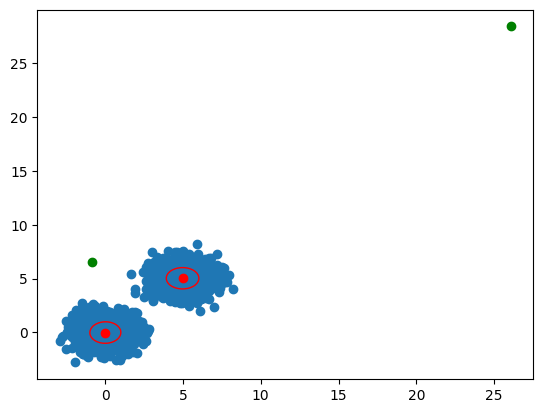

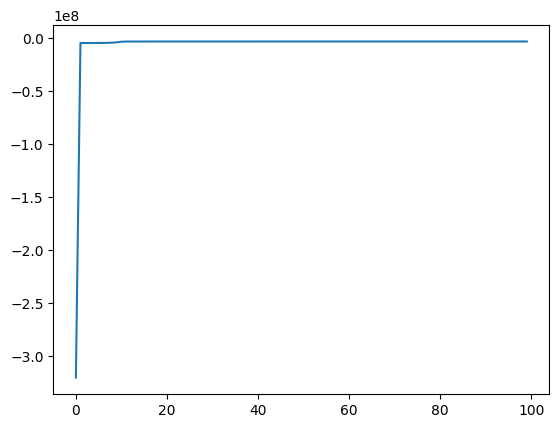

terminated early - convergence
Hamming Distance =  0.499


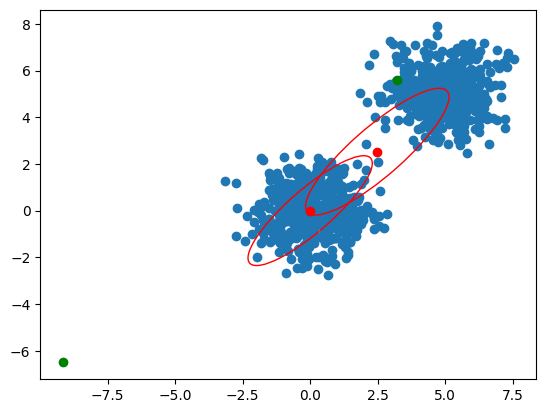

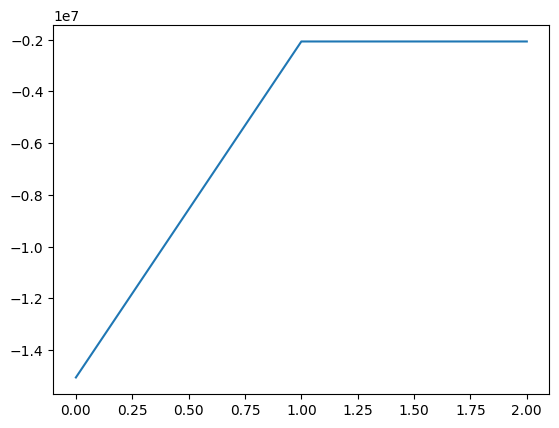

In [28]:
import time

# time the execution of test_hmmbatchsgd()
start_time = time.time()
test_hmmbatchsgd()
end_time = time.time()
elapsed_time_sgd = end_time - start_time

# time the execution of test_hmmbatchcd()
start_time = time.time()
test_hmmbatchcd()
end_time = time.time()
elapsed_time_cd = end_time - start_time


In [29]:
print("test_hmmbatchsgd() took {:.2f} seconds to run".format(elapsed_time_sgd))

print("test_hmmbatchcd() took {:.2f} seconds to run".format(elapsed_time_cd))

test_hmmbatchsgd() took 6.26 seconds to run
test_hmmbatchcd() took 0.56 seconds to run
